In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [41]:
path = 'data/'
!ls data

application_test.csv	     HomeCredit_columns_description.csv
application_test.csv.zip     installments_payments.csv
application_train.csv	     installments_payments.csv.zip
application_train.csv.zip    POS_CASH_balance.csv
bureau_balance.csv	     POS_CASH_balance.csv.zip
bureau_balance.csv.zip	     previous_application.csv
bureau.csv		     previous_application.csv.zip
bureau.csv.zip		     sample_submission.csv
credit_card_balance.csv      sample_submission.csv.zip
credit_card_balance.csv.zip  subm
df_pref			     tmp


# View data

In [4]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [5]:
def display_allRows(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 10):
            display(df)

In [17]:
application_train = pd.read_csv(path + 'application_train.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
bureau = pd.read_csv(path + 'bureau.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
pos_cash_balance = pd.read_csv(path+'POS_CASH_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')

# Feature Engineering

Code from https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [154]:
data = df_app_test
data.shape

(48744, 121)

In [155]:
#Bureau data

#Average Values for all bureau features
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']

#Merge into data
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')
data.shape

(48744, 135)

In [156]:
#Previous applications

#Count previous application
prev_apps_count = previous_application[['SK_ID_CURR','SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

#Average all other columns in previous application
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_'+ col for col in prev_apps_avg.columns]

#Merge into data
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
data.shape

(48744, 155)

In [157]:
#Installments Payments

## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]

#Merge into data
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
data.shape

(48744, 162)

In [158]:
#Pos cash balance

### count the number of pos cash for a given ID
pcb_count = pos_cash_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos_cash_balance['SK_ID_PREV'] = pos_cash_balance['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = pos_cash_balance.groupby('SK_ID_CURR').mean()

#Merge data
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')
data.shape

(48744, 168)

In [159]:
#Credit card balance

### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

#Merge data
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
data.shape

(48744, 189)

In [160]:
#Save data
data.to_feather('tmp/test_data')
!ls tmp

data  df_app  df_merge	df_merge_bru_preApp  test_data


# Learning

In [132]:
#df_merge = pd.read_feather('tmp/df_merge')
data = pd.read_feather('tmp/data')
data.shape

(307511, 190)

In [133]:
train_cats(data)
#train_cats(df_app)

In [134]:
df, y, nas = proc_df(data,'TARGET')#option max_n_cat=8
#df, y, nas = proc_df(df_app,'TARGET')

In [135]:
df.shape

(307511, 318)

In [136]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 8000
n_trn = len(df) - n_valid
#raw_train, raw_valid = split_vals(df_app, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((299511, 318), (299511,), (8000, 318), (8000,))

In [137]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [roc_auc_score(y_train, m.predict(X_train)), roc_auc_score(y_valid, m.predict(X_valid)),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [138]:
set_rf_samples(20000) # use reset_rf_samples() to reset

# Feature Importance

In [139]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 22.1 s, sys: 4.28 s, total: 26.4 s
Wall time: 21.6 s
[0.7609078669548608, 0.7439710557585276, 0.06589997374188428, 0.05959392052953382, 0.0567569433276105]


In [140]:
fi = rf_feat_importance(m,X_train); fi[:10]

cols       imp
41             EXT_SOURCE_2  0.095776
42             EXT_SOURCE_3  0.081916
40             EXT_SOURCE_1  0.033025
16               DAYS_BIRTH  0.022969
122             DAYS_CREDIT  0.019552
124     DAYS_CREDIT_ENDDATE  0.017255
146         p_DAYS_DECISION  0.015153
132      DAYS_CREDIT_UPDATE  0.014360
17            DAYS_EMPLOYED  0.013972
94   DAYS_LAST_PHONE_CHANGE  0.013866

In [141]:
def plot_fi(fi): return fi.plot('cols','imp','barh',figsize=(12,20), legend=False)

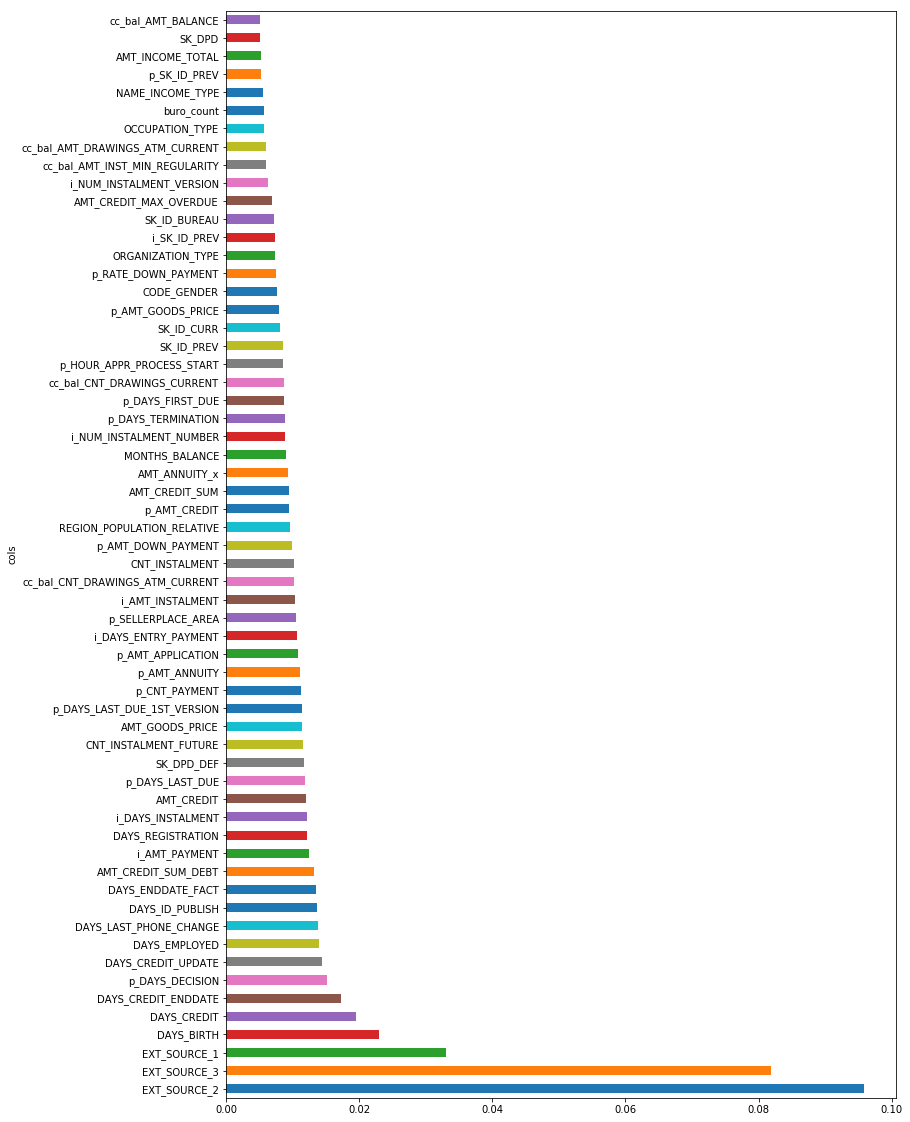

In [142]:
plot_fi(fi[:60])

In [143]:
fi[:30]

cols       imp
41                      EXT_SOURCE_2  0.095776
42                      EXT_SOURCE_3  0.081916
40                      EXT_SOURCE_1  0.033025
16                        DAYS_BIRTH  0.022969
122                      DAYS_CREDIT  0.019552
124              DAYS_CREDIT_ENDDATE  0.017255
146                  p_DAYS_DECISION  0.015153
132               DAYS_CREDIT_UPDATE  0.014360
17                     DAYS_EMPLOYED  0.013972
94            DAYS_LAST_PHONE_CHANGE  0.013866
19                   DAYS_ID_PUBLISH  0.013658
125                DAYS_ENDDATE_FACT  0.013503
129              AMT_CREDIT_SUM_DEBT  0.013175
161                    i_AMT_PAYMENT  0.012426
18                 DAYS_REGISTRATION  0.012245
158                i_DAYS_INSTALMENT  0.012196
7                         AMT_CREDIT  0.012047
152                  p_DAYS_LAST_DUE  0.011853
167                       SK_DPD_DEF  0.011770
165            CNT_INSTALMENT_FUTURE  0.011549
9                    AMT_GOODS_PRICE  0.011439
151      p_DAYS_LAST_DUE_1ST_VERSION  0.011427
148                    p_CNT_PAYMENT  0.011217
136                    p_AMT_ANNUITY  0.011117
137                p_AMT_APPLICATION  0.010754
159             i_DAYS_ENTRY_PAYMENT  0.010681
147               p_SELLERPLACE_AREA  0.010573
160                 i_AMT_INSTALMENT  0.010341
182  cc_bal_CNT_DRAWINGS_ATM_CURRENT  0.010176
164                   CNT_INSTALMENT  0.010150

In [144]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

60

In [145]:
df_keep = data[to_keep].copy()

In [146]:
display_allRows(df_keep.transpose())

0              1       \
EXT_SOURCE_2                                   0.262949       0.622246   
EXT_SOURCE_3                                   0.139376            NaN   
EXT_SOURCE_1                                   0.083037       0.311267   
DAYS_BIRTH                                        -9461         -16765   
DAYS_CREDIT                                        -874       -1400.75   
DAYS_CREDIT_ENDDATE                                -349         -544.5   
p_DAYS_DECISION                                    -606          -1305   
DAYS_CREDIT_UPDATE                             -499.875           -816   
DAYS_EMPLOYED                                      -637          -1188   
DAYS_LAST_PHONE_CHANGE                            -1134           -828   
DAYS_ID_PUBLISH                                   -2120           -291   
DAYS_ENDDATE_FACT                                -697.5       -1097.33   
AMT_CREDIT_SUM_DEBT                             49156.2              0   
i_AMT_PAYMENT                                   11559.2        64754.6   
DAYS_REGISTRATION                                 -3648          -1186   
i_DAYS_INSTALMENT                                  -295       -1378.16   
AMT_CREDIT                                       406598     1.2935e+06   
p_DAYS_LAST_DUE                                     -25       -1054.33   
SK_DPD_DEF                                            0              0   
CNT_INSTALMENT_FUTURE                                15        5.78571   
AMT_GOODS_PRICE                                  351000     1.1295e+06   
p_DAYS_LAST_DUE_1ST_VERSION                         125       -1004.33   
p_CNT_PAYMENT                                        24             10   
p_AMT_ANNUITY                                   9251.77          56554   
p_AMT_APPLICATION                                179055         435436   
i_DAYS_ENTRY_PAYMENT                           -315.421       -1385.32   
p_SELLERPLACE_AREA                                  500            533   
i_AMT_INSTALMENT                                11559.2        64754.6   
cc_bal_CNT_DRAWINGS_ATM_CURRENT                     NaN            NaN   
CNT_INSTALMENT                                       24        10.1071   
p_AMT_DOWN_PAYMENT                                    0         3442.5   
REGION_POPULATION_RELATIVE                     0.018801       0.003541   
p_AMT_CREDIT                                     179055         484191   
AMT_CREDIT_SUM                                   108132         254350   
AMT_ANNUITY_x                                   24700.5        35698.5   
MONTHS_BALANCE                                      -10       -43.7857   
i_NUM_INSTALMENT_NUMBER                              10           5.08   
p_DAYS_TERMINATION                                  -17       -1047.33   
p_DAYS_FIRST_DUE                                   -565       -1274.33   
cc_bal_CNT_DRAWINGS_CURRENT                         NaN            NaN   
p_HOUR_APPR_PROCESS_START                             9        14.6667   
SK_ID_PREV                                           19             28   
SK_ID_CURR                                       100002         100003   
p_AMT_GOODS_PRICE                                179055         435436   
CODE_GENDER                                           M              F   
p_RATE_DOWN_PAYMENT                                   0      0.0500303   
ORGANIZATION_TYPE                Business Entity Type 3         School   
i_SK_ID_PREV                                         19             25   
SK_ID_BUREAU                                6.15327e+06    5.88588e+06   
AMT_CREDIT_MAX_OVERDUE                          1681.03              0   
i_NUM_INSTALMENT_VERSION                        1.05263           1.04   
cc_bal_AMT_INST_MIN_REGULARITY                      NaN            NaN   
cc_bal_AMT_DRAWINGS_ATM_CURRENT                     NaN            NaN   
OCCUPATION_TYPE                                Labore

In [147]:
df_keep.shape

(307511, 60)

In [148]:
df, _, nas = proc_df(df_keep)

In [149]:
df.shape

(307511, 108)

In [150]:
X_train, X_valid = split_vals(df, n_trn)

In [151]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 11.3 s, sys: 1.54 s, total: 12.8 s
Wall time: 8.85 s
[0.7648708773674631, 0.7468945494771284, 0.07354753515416534, 0.06515437082880693, 0.06322732071113157]


In [152]:
m = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_depth=12, min_samples_leaf=30, max_features='sqrt', oob_score=True, random_state=2018)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 13s, sys: 8.91 s, total: 1min 22s
Wall time: 52.6 s
[0.7730915622518362, 0.7528951530623902, 0.0755660465730843, 0.06586626749219837, 0.06560468705387068]


# Interpretation

In [98]:
#Remove redundant features
from scipy.cluster import hierarchy as hc

In [130]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,50))
dendrogram = hc.dendrogram(z,labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


TypeError: '<' not supported between instances of 'str' and 'float'

# Test set

In [153]:
df_app_test = pd.read_csv(f'{PATH}application_test.csv', low_memory=False)

In [163]:
test_data = pd.read_feather('tmp/test_data')
test_data.shape

(48744, 189)

In [164]:
apply_cats(test_data, df_keep)

In [165]:
df_test_fi = test_data[to_keep].copy()

In [166]:
df_test_fi.shape

(48744, 60)

In [167]:
#df, y, nas = proc_df(df_app,'TARGET')

df_test,a,b = proc_df(df_test_fi,na_dict=nas) #passing in na_dict make sure the missing value columns aligns with training set

In [168]:
df_test.shape

(48744, 108)

In [169]:
predict = m.predict(df_test)

In [170]:
predict

array([0.11481, 0.12088, 0.04674, ..., 0.04852, 0.0457 , 0.16747])

In [171]:
df_pred = pd.DataFrame(predict)

In [172]:
df_pred.insert(0,'SK_ID_CURR',df_app_test['SK_ID_CURR'])

In [173]:
df_pred.rename({0:'TARGET'},axis='columns',inplace=True)

In [174]:
df_pred.head()

SK_ID_CURR    TARGET
0      100001  0.114809
1      100005  0.120876
2      100013  0.046737
3      100028  0.049196
4      100038  0.133846

In [175]:
df_pred.to_feather(f'{PATH}df_pref')

In [176]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM,exist_ok=True)
df_pred.to_csv(f'{SUBM}subm.csv', index = False)
FileLink(f'{SUBM}subm.csv')

/home/paperspace/kaggle/competitions/home-credit-default-risk/data/subm/subm.csv